## Load Dataset

In [24]:
import numpy as np 
import pandas as pd 

train=pd.read_csv('../data/labeledTrainData.tsv.zip', delimiter="\t")
test=pd.read_csv('../data/testData.tsv.zip', delimiter="\t")

sub=pd.read_csv('../data/sampleSubmission.csv')

## Data Preprocessing


In [25]:
import re
import json
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [26]:
train['review']=train['review'].apply(lambda x: BeautifulSoup(x,"html5lib").get_text())
test['review']=test['review'].apply(lambda x: BeautifulSoup(x,"html5lib").get_text())

In [27]:
train['review']=train['review'].apply(lambda x: re.sub("[^a-zA-Z]"," ",x))
test['review']=test['review'].apply(lambda x: re.sub("[^a-zA-Z]"," ",x))

In [28]:
stops = set(stopwords.words("english"))

for i in range(0,25000) : 
    review = train.iloc[i,2] # review column : 2 
    review = review.lower().split()
    words = [r for r in review if not r in stops]
    clean_review = ' '.join(words)
    train.iloc[i,2] = clean_review

In [29]:
for i in range(0,25000) : 
    review = test.iloc[i,1] # review column : 1
    review = review.lower().split()
    words = [r for r in review if not r in stops]
    clean_review = ' '.join(words)
    test.iloc[i,1] = clean_review

<AxesSubplot:xlabel='sentiment', ylabel='word_n_2'>

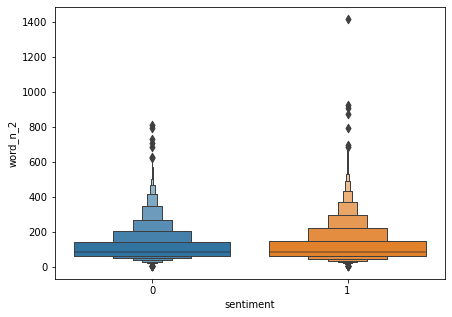

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

train['word_n_2'] = train['review'].apply(lambda x : len(x.split(' ')))
test['word_n_2'] = test['review'].apply(lambda x : len(x.split(' ')))

fig, axe = plt.subplots(1,1, figsize=(7,5))
sns.boxenplot(x=train['sentiment'], y=train['word_n_2'], data=train)

In [31]:
from keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(list(train['review'])+list(test['review']))
text_seq_tr=tk.texts_to_sequences(train['review'])
text_seq_te=tk.texts_to_sequences(test['review'])
word_ind=tk.word_index

In [32]:
print('Total word count is :',len(word_ind))

Total word count is : 101246


In [33]:
data_info={}
data_info['word_ind']=word_ind
data_info['word_len']=len(word_ind)+1

In [34]:
from keras.preprocessing.sequence import pad_sequences
pad_train=pad_sequences(text_seq_tr, maxlen=400) 
pad_test=pad_sequences(text_seq_te, maxlen=400) 

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(pad_train, train['sentiment'], random_state=77, test_size=0.07, stratify=train['sentiment'])

## Modeling


In [36]:
from keras import Sequential
from keras.layers import Dense, Embedding, Flatten

model=Sequential()
model.add(Embedding(101247,65, input_length=400))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'] )

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(patience=4) 
mc=ModelCheckpoint('best.h5',save_best_only=True)
model.fit(x_train,y_train, batch_size=128, epochs=10, validation_data=[x_valid,y_valid], callbacks=[es,mc]) 

Epoch 1/10
182/182 [==============================] - 75s 374ms/step - loss: 0.4870 - acc: 0.7591 - val_loss: 0.2645 - val_acc: 0.9029
Epoch 2/10
182/182 [==============================] - 107s 591ms/step - loss: 0.1661 - acc: 0.9430 - val_loss: 0.2382 - val_acc: 0.9006
Epoch 3/10
182/182 [==============================] - 51s 279ms/step - loss: 0.0615 - acc: 0.9865 - val_loss: 0.2392 - val_acc: 0.9006
Epoch 4/10
182/182 [==============================] - 50s 274ms/step - loss: 0.0234 - acc: 0.9973 - val_loss: 0.2487 - val_acc: 0.8978
Epoch 5/10
182/182 [==============================] - 47s 258ms/step - loss: 0.0104 - acc: 0.9994 - val_loss: 0.2596 - val_acc: 0.8978
Epoch 6/10
182/182 [==============================] - 52s 283ms/step - loss: 0.0057 - acc: 0.9999 - val_loss: 0.2691 - val_acc: 0.8989


In [38]:
model.load_weights('best.h5')

In [39]:
res=model.predict(pad_test, batch_size=128)

In [40]:
res

array([[0.00356253, 0.99643743],
       [0.9984724 , 0.00152757],
       [0.38636   , 0.61364   ],
       ...,
       [0.97362447, 0.02637556],
       [0.00754007, 0.99245995],
       [0.62842107, 0.3715789 ]], dtype=float32)

In [41]:
sub['sentiment_pro']=res[:,1]

In [42]:
sub.loc[sub['sentiment_pro']>=0.5,"sentiment"]=1
sub.loc[sub['sentiment_pro']<0.5,"sentiment"]=0

- Use *`0.5 as thereshold`* to specify one or zero

In [43]:
sub=sub[['id','sentiment']]

In [44]:
sub.to_csv('result.csv',index=False)